<a href="https://colab.research.google.com/github/anquin129/NeuroAI/blob/main/ErrorDetect1dCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D CNN Model for Error Detection with EEG Data

### Mount HDF5 file from Google Drive

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Definitions

In [2]:
# separate top_keys by trials
## redundant for now
def sep_trials_by_cond(file, keys):

    conditions = {'A': [], 'B': [], 'C':[]}

    for key in keys:
        k = int(key)
        data = file[key]
        if 1 <= k <= 34:
            conditions['A'].append(data)
        elif 101 <= k <= 134:
            conditions['B'].append(data)
        elif 501 <= k <= 534:
            conditions['C'].append(data)
    return conditions


# extract ERN
def extract_ern_peaks(trials, sampling_rate, channel_idx=0, start_ms=0, end_ms=100):
    
    start_idx = int((start_ms / 1000) * sampling_rate)
    end_idx = int((end_ms / 1000) * sampling_rate)

    peak_latencies = []
    for trial in trials:
        signal = trial[channel_idx, start_idx:end_idx]
        peak_idx = np.argmin(signal)
        latency_ms = (start_idx + peak_idx) * 1000 / sampling_rate
        peak_latencies.append(latency_ms)
    
    return np.array(peak_latencies)


# visualize ERN
def plot_ern_waveform(trials, latencies_ms, sampling_rate, channel_idx=0, n_trials_to_plot=5):

    time = np.linspace(0, trials.shape[2] / sampling_rate * 1000, trials.shape[2])

    for i in range(min(n_trials_to_plot, len(trials))):
        signal = trials[i, channel_idx, :]
        peak_time = latencies_ms[i]
        peak_idx = int((peak_time / 1000) * sampling_rate)

        plt.figure(figsize=(6,3))
        plt.plot(time, signal, label=f'trial {i}')
        plt.plot(peak_time, signal[peak_idx], 'ro', label='ERN Peak')
        plt.title(f"Trial {i} - ERN Peak at {peak_time:.1f} ms")
        plt.xlabel("Time (ms)")
        plt.ylabel("Amplitude (uV)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
                   

# separate epoch data into marked and non-marked (training and testing)

In [3]:
import os
print(os.getcwd())

c:\Users\aandr\OneDrive\Pursuits\DeLab\ErrorDetectionEEG_rprd


## EEG data processing pipeline

In [4]:
def process_eeg_data(file_path, selected_keys, debug_mode=True):

    with h5py.File(file_path, 'r') as f:
        
        channel_names = []  
        all_data = []
        all_labels = []

        top_keys = list(f.keys())
        print(f"Top-level keys: {top_keys}")

        conditions = sep_trials_by_cond(file=f, keys=top_keys) 
        print('Conditions: ', conditions)

        key = f['1']
        print('Keys:', key.keys()) # (channel_names, eeg_data, labels)

        # for loop x subject in selected subjects  
        
        for subject_key in selected_keys:

            group = f[subject_key]
            
            if 'channel_names' in group:
                channel_names = group['channel_names'][:]
                channel_names = [name.decode('utf-8') for name in channel_names]
                print('Channel names:', channel_names)
                print('channel_names length:', len(channel_names))
            else:
                print(f"'{subject_key}' group does not contain 'channel_names'")

            if 'eeg_data' in group:
                eeg_data_subject = group['eeg_data'][:]
                for trial in eeg_data_subject:
                    all_data.append(trial)
                print(f"Data shape: {eeg_data_subject.shape}")
                print(f"Data dtype: {eeg_data_subject.dtype}")
            else:
                print(f"'{subject_key}' group does not contain 'eeg_data'")

            if 'labels' in group:
                labels = group['labels'][:]
                all_labels.extend(labels)
                print(f"Label shape: {labels.shape}")
                print(f"Label dtype: {labels.dtype}")
            else:
                print(f"'{subject_key}' group does not contain 'labels'")

            # find error trial
            error_indices = np.where(labels == 1)[0]
            print('Error trial indices:', error_indices)

            if len(error_indices) == 0:
                print("No error trials found for this subject.")
            else:
                error_trials = eeg_data_subject[error_indices]
                print("Error trial EEG shape", error_trials.shape)

            # select frontocentral channels
            # preferred_channels = ['FCz', 'Cz', 'Fz']
            # available_channels = [ch for ch in preferred_channels if ch in channel_names]

            # if not available_channels:
                # print("No frontocentral channels found.")
            # else:
                # print("Using channel:", available_channels[0])
                # ch_idx = channel_names.index(channel_names[0]) ?

            sampling_rate = 256 # Hz
            n_times = eeg_data_subject.shape[2]
            time_axis = np.linspace(0, 1000, n_times) # ms

            # extract ERN peaks
            ern_latencies = extract_ern_peaks(trials=error_trials, sampling_rate=sampling_rate, channel_idx=0, start_ms=0, end_ms=100)

            print('ERN Latencies: ', ern_latencies)

            # visualize ERN
            # plot_ern_waveform(trials=error_trials, latencies_ms=ern_latencies, sampling_rate=sampling_rate, channel_idx=0, n_trials_to_plot=5)

        # Stack trials into single arrays
        X = np.array(all_data)
        y = np.array(all_labels)
        y = np.squeeze(y)

        # Apply z-score normalization
        X_mean = np.mean(X)
        X_std = np.std(X)
        X = (X - X_mean) / X_std

        if debug_mode:
            print(f"Processed data shape: {X.shape}, labels shape: {y.shape}")
            print(f"Data mean after normalization: {np.mean(X):.6f}")
            print(f"Data std after normalization: {np.std(X):.6f}")
            print(f"Data range: [{np.min(X):.3f}, {np.max(X):.3f}]")

        return X, y

## Training a 1D CNN model

In [5]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, UpSampling1D, GlobalAveragePooling1D, Reshape
from tensorflow.keras.optimizers import Adam # to compile model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.losses import BinaryFocalCrossentropy # for focal loss
from tensorflow.keras.regularizers import l2 

# Call data processing function to get X and y
selected_keys = [str(i) for i in range(1,11)]

X, y = process_eeg_data('C:/Users/aandr/OneDrive/Pursuits/DeLab/ErrorDetectionEEG_rprd/data/epoch_crops.h5', selected_keys=selected_keys, debug_mode=True)

X = np.transpose(X, (0, 2, 1))  # (samples, 256, 33)

# Input X and y through convolution layer(s)
input_shape = (256,33) # Excluding sample dimension
inputs = Input(shape=input_shape)

# Training (X -> y)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size=0.2, random_state=42, stratify=y)
# Split again for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Validation class distribution: {np.bincount(y_val)}")

# Calculate class weights
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight('balanced', classes=classes,
                                                  y=y_train)
# Convert weights to dict format required by fit
class_weight_dict = dict(zip(classes, class_weights))
print(f"Class weights: {class_weight_dict}")

# Autoencoder 

# Encoder
x = Conv1D(filters=33, kernel_size=25, activation='relu',
                 padding='same', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = MaxPooling1D(pool_size=2, padding='same')(x) # Pooling layer

x = Conv1D(filters=16, kernel_size=25, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = Conv1D(filters=8, kernel_size=25, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
encoded = MaxPooling1D(pool_size=2, padding='same')(x) # bottleneck

# Decoder
x = Conv1D(filters=8, kernel_size=25, activation='relu', padding='same', kernel_regularizer=l2(0.001))(encoded)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = UpSampling1D(size=2)(x)

x = Conv1D(filters=16, kernel_size=25, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = UpSampling1D(size=2)(x)

x = Conv1D(filters=33, kernel_size=25, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = UpSampling1D(size=2)(x)

decoded = x

# Full autoencoder
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Autoencoder callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)

# Encoder model
encoder = Model(inputs, encoded)

# Train autoencoder (X -> X)
autoencoder.fit(X_train, X_train,
                validation_data=(X_val, X_val),
                epochs=1000, batch_size=16,
                callbacks=[reduce_lr, early_stopping])

# Extract features for classification
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)



# Classifier
model = Sequential()

# Encoder-like layers (same as above)
model.add(Conv1D(32, kernel_size=5, activation='relu', padding='same', input_shape=(32,8)))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(16, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))

# Flatten last layer output
model.add(Flatten()) # Converts 3D output -> 1D

## Dense layers
# Set 1
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001))) # learn higher-level features
model.add(Dropout(0.5)) # Randomly turns off 50% of neurons in training

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), # Adam adjusts LRs during training
              loss=BinaryFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=False),
              metrics=['accuracy', AUC(), Precision(), Recall()])

model.summary()

from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
import time

# Find sum training time
class TimeHistory(Callback):
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, epoch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)

# Callback instance
time_callback = TimeHistory()

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.5,
  patience=10,
  min_lr = 0.00001,
  verbose=1
)

# Early stopping
early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=20,
  restore_best_weights = True,
  verbose=1
)

# Fit model
out = model.fit(X_train_encoded, y_train, epochs=100, batch_size=16, validation_data=(X_val_encoded, y_val), class_weight=class_weight_dict, callbacks=[time_callback, reduce_lr, early_stopping])

# Calculate total training time
total_train_time = sum(time_callback.times)
print(f"Total training time: {total_train_time:.2f} seconds")

Top-level keys: ['1', '10', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '134', '14', '15', '16', '17', '18', '19', '2', '20', '21', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '34', '4', '5', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '512', '513', '514', '515', '516', '517', '518', '519', '520', '521', '523', '524', '525', '526', '527', '528', '529', '530', '531', '532', '534', '6', '7', '8', '9']
Conditions:  {'A': [<HDF5 group "/1" (3 members)>, <HDF5 group "/10" (3 members)>, <HDF5 group "/12" (3 members)>, <HDF5 group "/13" (3 members)>, <HDF5 group "/14" (3 members)>, <HDF5 group "/15" (3 members)>, <HDF5 group "/16" (3 members)>, <HDF5 group "/17" (3 members)>, <HDF5 group "/18" (3 members)>, <HDF5 group "/19" (3 members)>, <HDF5 group "/2" (3 members)>, <H

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 33)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 256, 33)        │        27,258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 33)        │           132 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 33)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 128, 33)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 16)        │        13,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 8)          │         3,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 32, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 32, 8)          │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 64, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 64, 16)         │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 128, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 128, 33)        │        13,233 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 62,195 (242.95 KB)

 Trainable params: 61,967 (242.06 KB)

 Non-trainable params: 228 (912.00 B)

Epoch 1/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.0668 - val_loss: 0.7998 - learning_rate: 0.0010
Epoch 2/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1151 - val_loss: 0.6256 - learning_rate: 0.0010
Epoch 3/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.8095 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 4/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.7547 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 5/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6753 - val_loss: 0.4653 - learning_rate: 0.0010
Epoch 6/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5100 - val_loss: 0.4836 - learning_rate: 0.0010
Epoch 7/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7394 - val_loss: 0.4603 - learning_rate: 0.0010
Epoch 8/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.7368 - val_loss: 0.4287 - learning_rate: 0.0010
Epoch 9/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5044 - val_loss: 0.3267 - learn

C:\Users\aandr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 32, 32)         │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 16, 16)         │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 8, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,049 (31.44 KB)

 Trainable params: 8,049 (31.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5326 - auc: 0.5799 - loss: 0.2236 - precision: 0.1389 - recall: 0.6007 - val_accuracy: 0.8000 - val_auc: 0.8352 - val_loss: 0.1544 - val_precision: 0.3191 - val_recall: 0.6522 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7374 - auc: 0.8059 - loss: 0.1662 - precision: 0.2759 - recall: 0.7280 - val_accuracy: 0.7675 - val_auc: 0.8586 - val_loss: 0.1526 - val_precision: 0.3135 - val_recall: 0.8587 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7456 - auc: 0.8562 - loss: 0.1494 - precision: 0.3194 - recall: 0.8474 - val_accuracy: 0.8338 - val_auc: 0.8576 - val_loss: 0.1173 - val_precision: 0.3787 - val_recall: 0.6957 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8118 - auc: 0.8754 - loss: 0.1289 - precision: 0.3622 - recall: 0.8091 - val_accuracy: 0.7650 - val_auc: 0.8734 - val_loss: 0.1376 -

Testing and validating data

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

# Testing (X sample -> y pred)
X_test_encoded = encoder.predict(X_test)
y_pred = model.predict(X_test_encoded)
print(f"Predicted probabilities (y_pred): {y_pred}")

# Find optimal threshold
from sklearn.metrics import confusion_matrix
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for t in thresholds:
  y_pred_binary = (y_pred > t).astype(int)
  accuracy_percentage = accuracy_score(y_test, y_pred_binary) * 100
  print(f"Threshold: {t}, Accuracy: {accuracy_percentage:.2f}%")
  cm = confusion_matrix(y_test, y_pred_binary)
  tn, fp, fn, tp = cm.ravel()
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  roc_auc = roc_auc_score(y_test, y_pred_binary)
  print(f"Precision score: {precision_score(y_test, y_pred_binary):.2f}")
  print(f"Sensitivity: {sensitivity:.2f}")
  print(f"Specificity: {specificity:.2f}")
  print(f"ROC AUC: {roc_auc:.2f}\n")


# Classification w/ optimal threshold (accounting for precision, sensitivity, and overall accuracy)
y_pred_classes = (y_pred > 0.3).astype(int)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predicted probabilities (y_pred): [[0.28124684]
 [0.03726465]
 [0.08482229]
 [0.10841025]
 [0.01867577]
 [0.3758601 ]
 [0.07302567]
 [0.47301856]
 [0.1502036 ]
 [0.06635971]
 [0.09982756]
 [0.5319102 ]
 [0.08800045]
 [0.3597329 ]
 [0.12344763]
 [0.4693788 ]
 [0.03309285]
 [0.09495566]
 [0.4195318 ]
 [0.32499033]
 [0.3810719 ]
 [0.0360803 ]
 [0.12977749]
 [0.06044653]
 [0.05855733]
 [0.3437093 ]
 [0.5692234 ]
 [0.48061994]
 [0.09132949]
 [0.03454426]
 [0.06170718]
 [0.1265309 ]
 [0.16477172]
 [0.12026815]
 [0.7050737 ]
 [0.04634243]
 [0.07526894]
 [0.30173206]
 [0.49869528]
 [0.0683975 ]
 [0.37301204]
 [0.08473013]
 [0.0865186 ]
 [0.46290046]
 [0.1174878 ]
 [0.31034407]
 [0.2165579 ]
 [0.45214596]
 [0.01456759]
 [0.17940511]
 [0.0644803 ]
 [0.0478925 ]
 [0.7126665 ]
 [0.2945526 ]
 [0.45573714]
 [0.0306813 ]
 [0.23344317]
 [0.10009479]
 [0.3533426 ]
 [0.17281269]
 [0.37283194]
 [0.0367766 ]
 [0.5698967 ]
 [0.2

Note: After calculating the optimal threshold value of [0.1, 0.2, 0.3, 0.4, 0.5], the sensitivity (~0.75) is best with a binary classification threshold of 0.1, and decreases as the threshold increases / overall accuracy score increases.

As I used lower threshold values [0.01, 0.05], the sensitivity increased more but with a tradeoff cost of the specificity and overall accuracy scores.

The lower the threshold, the lower the precision score.

### Other validation techniques

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       708
           1       0.34      0.75      0.46        92

    accuracy                           0.80       800
   macro avg       0.65      0.78      0.67       800
weighted avg       0.89      0.80      0.83       800



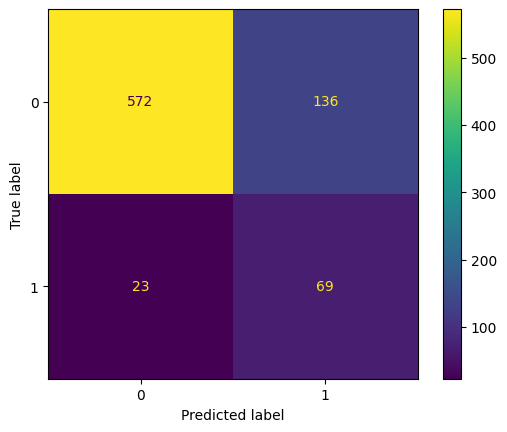

Sensitivity: 0.75
Specificity: 0.81


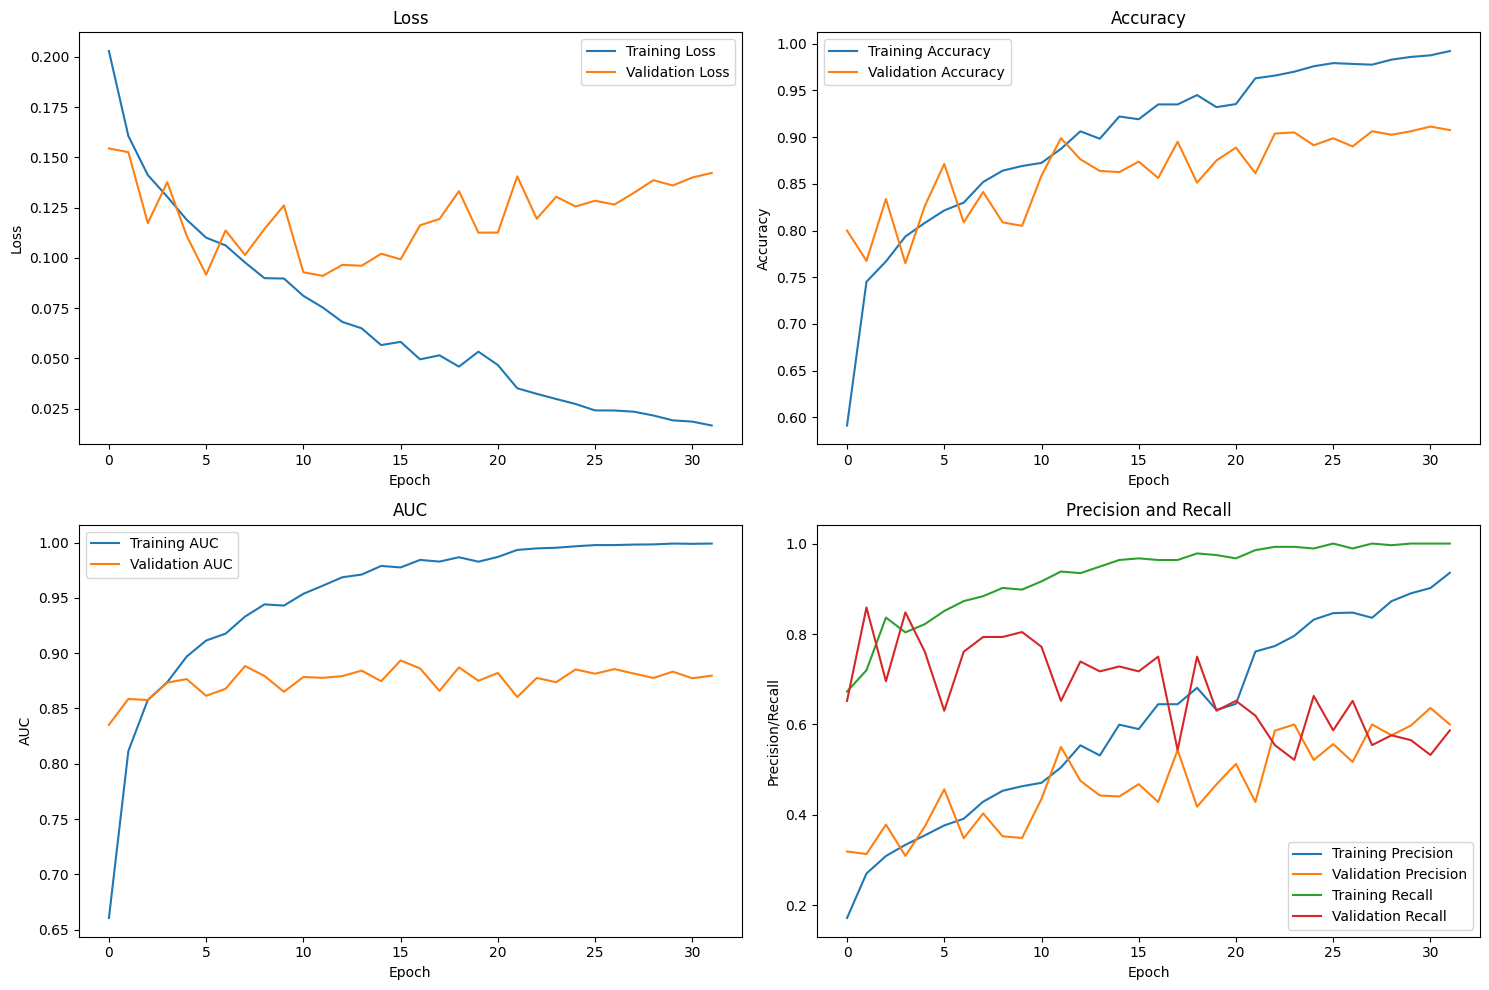

In [11]:
# Print classification report
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Calculate sensitivity, specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Plot loss
axes[0, 0].plot(out.history['loss'], label='Training Loss')
axes[0, 0].plot(out.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot accuracy
axes[0, 1].plot(out.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(out.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(out.history['auc'], label='Training AUC')
axes[1, 0].plot(out.history['val_auc'], label='Validation AUC')
axes[1, 0].set_title('AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()

# Plot precision/recall
axes[1, 1].plot(out.history['precision'], label='Training Precision')
axes[1, 1].plot(out.history['val_precision'], label='Validation Precision')
axes[1, 1].plot(out.history['recall'], label='Training Recall')
axes[1, 1].plot(out.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Precision and Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Precision/Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

ROC AUC: 0.83


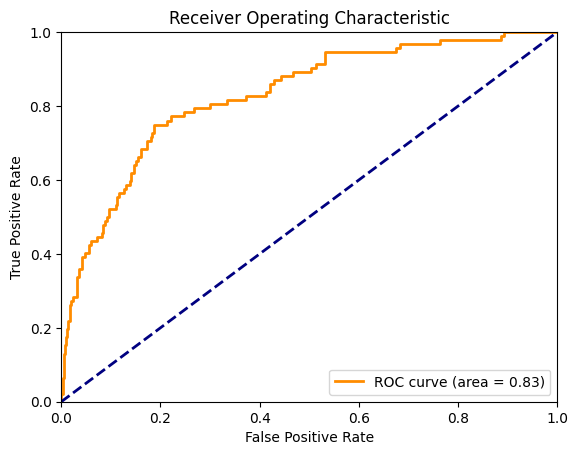

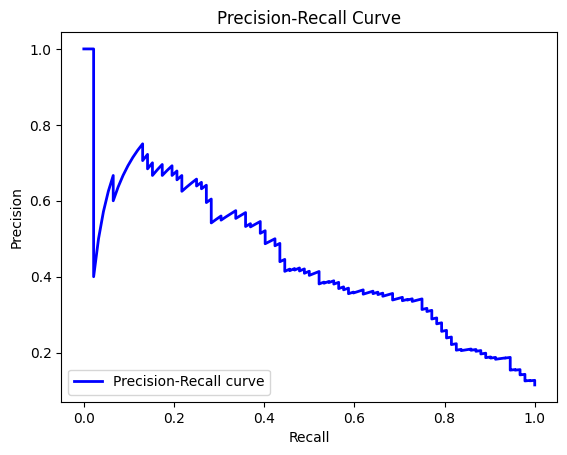

In [12]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc:.2f}")

# Plot ROC curve
fig1, ax1 = plt.subplots()
ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")
plt.show()

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot Precision-Recall curve
fig2, ax2 = plt.subplots()
ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")
plt.show()